In [1]:
DEBUG = False

In [2]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [3]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None
load_last = True

n_folds = 5
backbone = 'tf_efficientnetv2_s.in21k_ft_in1k'

image_size = 224
n_slice_per_c = 30 # liver,spleen,left kidney, right kidney 
in_chans = 6

init_lr = 23e-5
eta_min = 23e-6
batch_size = 2
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order_v1 = 0.2

data_dir = './preprocessed2'
use_amp = True
num_workers = 4
out_dim = 3

n_epochs = 75

log_dir = './logs'
model_dir = './models_cls'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=False, always_apply=False, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=cv2.BORDER_REFLECT101, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=(1,3)),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=.5),
        albumentations.GridDistortion(num_steps=5, distort_limit=.5),
    ], p=0.5),

    albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/sronen/code/.venv/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# DataFrame

In [5]:
from sklearn.model_selection import KFold

organ_dict = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold


df=df_p.merge(df_s,on="patient_id")

pid=[]
sid = []
cs = []
label = []
fold = []
hu=[]
for row in df.to_dict(orient="records"):
    for i in [0,1,2]:
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        cs.append(i)
        hu.append(row["aortic_hu"])
        organ=organ_dict[i]
        label.append([row[f'{organ}_healthy'],row[f'{organ}_low'],row[f'{organ}_high']])
        fold.append(row["fold"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'c': cs,
    "hu":hu,
    'label': label,
    'fold': fold
})

df = df.sample(16).reset_index(drop=True) if DEBUG else df

df.tail(10)


,patient_id,series_id,c,hu,label,fold
14123,9961,63032,2,143.75,"[1, 0, 0]",4
14124,9980,40214,0,103.00,"[1, 0, 0]",1
14125,9980,40214,1,103.00,"[0, 0, 1]",1
14126,9980,40214,2,103.00,"[1, 0, 0]",1
14127,9980,40466,0,135.00,"[1, 0, 0]",1
14128,9980,40466,1,135.00,"[0, 0, 1]",1
14129,9980,40466,2,135.00,"[1, 0, 0]",1
14130,9983,10806,0,168.00,"[1, 0, 0]",1
14131,9983,10806,1,168.00,"[0, 0, 1]",1
14132,9983,10806,2,168.00,"[1, 0, 0]",1


# Dataset

In [6]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cid = row.c
        
        images = []
        
        filepath=os.path.join(data_dir, f'{row.patient_id}_{row.series_id}.npz')
        image3d = np.load(filepath)['arr_0'] # slice,channel,H,W
        istart=n_slice_per_c*cid
        iend=istart+n_slice_per_c
        for ind in list(range(istart,iend)):
            image=image3d[ind,...].transpose(1,2,0).astype(np.uint8)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * (iend-istart)).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]

            return images, labels
        else:
            return torch.tensor(images).float()

In [7]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

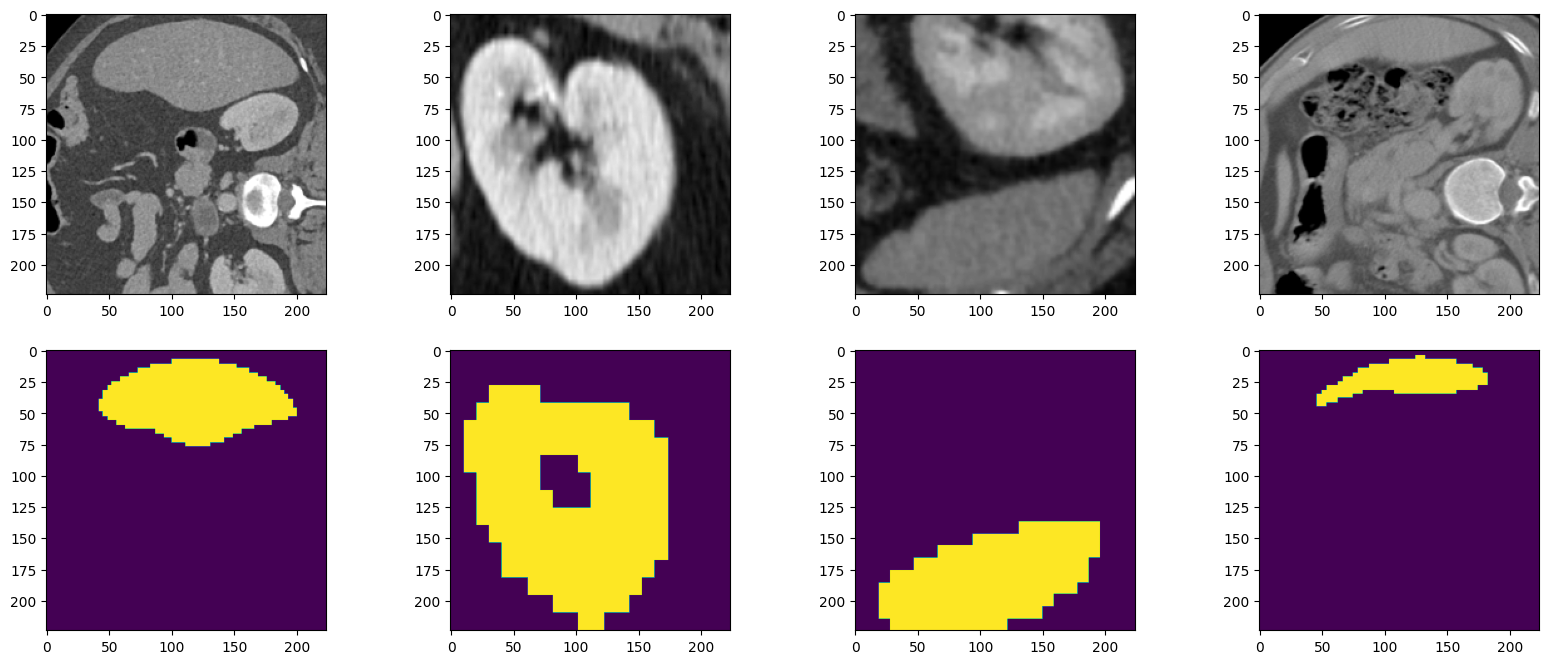

In [8]:
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    sel=7
    axarr[0, p].imshow(imgs[sel][3],cmap="gray")
    axarr[1, p].imshow(imgs[sel][-1])

# Model

In [9]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c,out_dim).contiguous()

        return feat

In [10]:
m = TimmModel(backbone)
m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape

torch.Size([2, 30, 3])

In [11]:
weight=torch.FloatTensor([1,2,4]).cuda()
ce = nn.CrossEntropyLoss(weight=weight,reduction='mean', label_smoothing=0.0)


def criterion(logits, targets):
    logits=logits.view(-1,out_dim)
    targets=targets.view(-1,out_dim)
    loss = ce(logits, targets)
    return loss

In [12]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))


def mix_up(images1,labels1):
    # Unpack two datasets
    batch_size = images1.shape[0]
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1, 1, 1,1))
    y_l = l.reshape((batch_size, 1,1))
    idx = torch.randperm(batch_size).cuda()
    images2=images1[idx,...]
    labels2=labels1[idx,...]
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images1 * x_l + images2 * (1 - x_l)
    labels = labels1 * y_l + labels2 * (1 - y_l)
    return (images, labels)


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        if random.random() < p_mixup:
            images, targets = mix_up(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    return np.mean(valid_loss)


/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

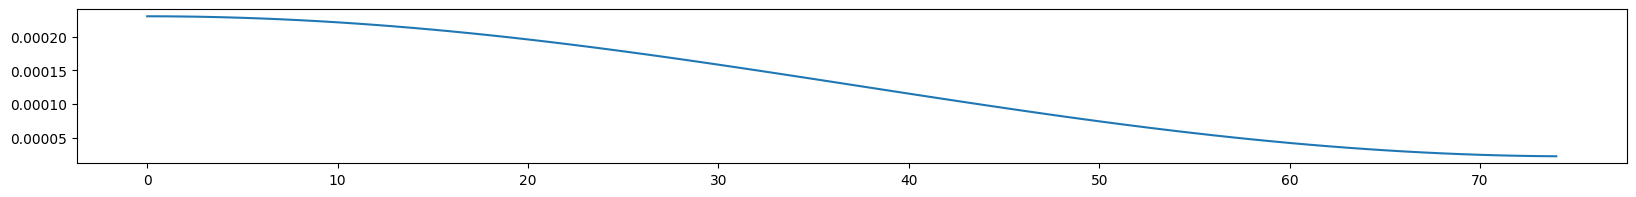

In [13]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [14]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [15]:
run(0)
#run(1)
#run(2)
#run(3)
#run(4)

11337 2796
Mon Sep  4 13:52:30 2023 Epoch: 1


smth:0.6387: 100%|██████████| 1398/1398 [03:01<00:00,  7.70it/s]


Mon Sep  4 14:15:09 2023 Fold 0, Epoch 1, lr: 0.0002300, train loss: 0.77910, valid loss: 0.87475, metric: 0.874751.
metric_best (inf --> 0.874751). Saving model ...
Mon Sep  4 14:15:10 2023 Epoch: 2


smth:0.6592: 100%|██████████| 1398/1398 [02:49<00:00,  8.25it/s]


Mon Sep  4 14:38:07 2023 Fold 0, Epoch 2, lr: 0.0002299, train loss: 0.76608, valid loss: 0.87185, metric: 0.871846.
metric_best (0.874751 --> 0.871846). Saving model ...
Mon Sep  4 14:38:08 2023 Epoch: 3


smth:0.6671: 100%|██████████| 1398/1398 [02:56<00:00,  7.92it/s]


Mon Sep  4 15:01:09 2023 Fold 0, Epoch 3, lr: 0.0002296, train loss: 0.75882, valid loss: 0.84711, metric: 0.847114.
metric_best (0.871846 --> 0.847114). Saving model ...
Mon Sep  4 15:01:10 2023 Epoch: 4


smth:0.6622: 100%|██████████| 1398/1398 [02:51<00:00,  8.16it/s]


Mon Sep  4 15:24:09 2023 Fold 0, Epoch 4, lr: 0.0002292, train loss: 0.75721, valid loss: 0.85561, metric: 0.855610.
Mon Sep  4 15:24:10 2023 Epoch: 5


smth:0.7088:  37%|███▋      | 2081/5668 [07:19<12:36,  4.74it/s]


KeyboardInterrupt: 